# Tutorial 03

## partial-sky ABS pipeline (without noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

fidmap = dict()
fidmap[95] = mapcmb

fullbeam = dict()
fullbeam[23] = (52.8/60.)*np.pi/180.
fullbeam[95] = (19./60.)*np.pi/180.
fullbeam[150] = (11./60.)*np.pi/180.
fullbeam[353] = (4.94/60.)*np.pi/180.

fullmap = dict()
fullmap[23] = hp.smoothing(map23f+mapcmb,fwhm=fullbeam[23],verbose=0)
fullmap[95] = hp.smoothing(map95f+mapcmb,fwhm=fullbeam[95],verbose=0)
fullmap[150] = hp.smoothing(map150f+mapcmb,fwhm=fullbeam[150],verbose=0)
fullmap[353] = hp.smoothing(map353f+mapcmb,fwhm=fullbeam[353],verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200
est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
est.targets = 'T'
cmb_dl_t = est.autoBP(mapcmb)
est.targets = 'EB'
cmb_dl_eb = est.autoBP(mapcmb)
cmb_dl = np.vstack([cmb_dl_t[0],cmb_dl_t[1],cmb_dl_eb[1],cmb_dl_eb[2]])

- PS estimation requires a built-in PS estimator (by default NaMaster)
- use `abspipe`

ABS T mode relative error dist: mean=-0.040334, std=0.034979
ABS E mode relative error dist: mean=-0.011289, std=0.008678
ABS B mode relative error dist: mean=-0.010940, std=0.011537


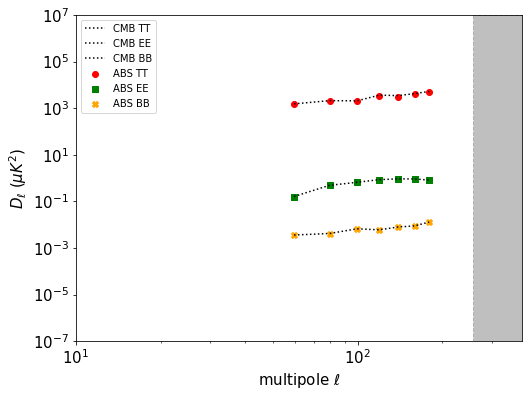

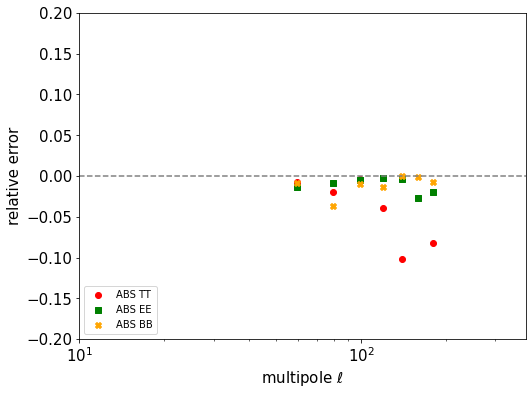

In [2]:
# T maps
pipeline = af.abspipe(fullmap,mask=mask,fwhms=fullbeam,targets='T',fiducials=fidmap)
signal, fiducial, noise = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
modes, rslt_t, info = pipeline.analyse(signal,noise,shift=None,threshold=None)
# Q,U maps
pipeline.targets = 'EB'
signal, fiducial, noise = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
modes, rslt_eb, info = pipeline.analyse(signal,noise,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(modes,rslt_t[0],
           color='red',marker='o',label=r'ABS TT')
ax.scatter(modes,rslt_eb[0],
           color='green',marker='s',label=r'ABS EE')
ax.scatter(modes,rslt_eb[1],
           color='orange',marker='X',label=r'ABS BB')

ax.plot(cmb_dl[0],cmb_dl[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],color='black',linestyle=':',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(8,6))

tt_rel = (rslt_t[0]-cmb_dl[1])/cmb_dl[1]
ee_rel = (rslt_eb[0]-cmb_dl[2])/cmb_dl[2]
bb_rel = (rslt_eb[1]-cmb_dl[3])/cmb_dl[3]

ax.scatter(modes,tt_rel,
            color='red',marker='o',label=r'ABS TT')
ax.scatter(modes,ee_rel,
            color='green',marker='s',label=r'ABS EE')
ax.scatter(modes,bb_rel,
            color='orange',marker='X',label=r'ABS BB')
ax.plot((10,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.2,0.2))
ax.set_xlim((10,3*NSIDE))

print ('ABS T mode relative error dist: mean=%f, std=%f' % (np.mean(tt_rel), np.std(tt_rel)))
print ('ABS E mode relative error dist: mean=%f, std=%f' % (np.mean(ee_rel), np.std(ee_rel)))
print ('ABS B mode relative error dist: mean=%f, std=%f' % (np.mean(bb_rel), np.std(bb_rel)))

end